# Data recording and analysis

<div class="admonition note">
**Topics**: Spatial data saving, Data visualization, HDF5 format, XDMF format, Paraview.
</div>

The corresponding python script: [STEPS_Tutorial_DataSaving.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_DataSaving.py)

As we just saw in the previous chapter, recording and analyzing data can quickly become relatively code-intensive when the complexity of the model and geometry increases. In addition, it is often desirable to save the recorded data to separate files that can be read at a later time for plotting.
In this chapter we will introduce database handlers that will let us record data from different simulations to a database (either [SQLite](https://www.sqlite.org/index.html) or [HDF5](https://www.hdfgroup.org/solutions/hdf5)). We will then present a specialized database handler that uses the [XDMF](https://www.xdmf.org/index.php/Main_Page) file format to easily record spatial data and visualize it with [Paraview](https://www.paraview.org/), a scientific visualization software.

Required python packages for this chapter: [h5py](https://docs.h5py.org/en/latest/build.html) and [scipy](https://scipy.org/).
In the second part of the chapter, it can be helpful to have installed [Paraview](https://www.paraview.org/), but it is not absolutely necessary.

Some simulations in this chapter take a long time to run, the files generated by the simulations can be downloaded from the [github repository](https://github.com/CNS-OIST/STEPS_Example/raw/master/user_manual/source/data/DataSaving_HDF5_data.zip).

## Well-mixed Brusselator model

Since the focus will be put on the recording part of STEPS script, we will use a very simple model and geometry in this chapter. We will model the [Brusselator](https://en.wikipedia.org/wiki/Brusselator) chemical oscillator. We will first use a well-mixed geometry in order to introduce the parameter-saving capabilities of databases.

The Brusselator model contains the following reactions:
\begin{equation}
A \rightarrow X
\end{equation}

\begin{equation}
X \rightarrow E
\end{equation}

\begin{equation}
B + X \rightarrow Y + D
\end{equation}

\begin{equation}
2X + Y \rightarrow 3X
\end{equation}

We consider $A$ and $B$ to be in vast excess so that the reactions do not significantly change their concentrations. We can then treat them as parameters $k_A$ and $k_B$ in the first and third reactions. We also ignore product species $D$ and $E$ that are not further involved in the reactions. The reduced system is:

\begin{equation}
\varnothing \overset{k_A}{\rightleftarrows} X \overset{k_B}{\rightarrow} Y
\end{equation}

\begin{equation}
2X + Y \rightarrow 3X
\end{equation}

### Declaring the STEPS model

We declare the corresponding biochemical model and the well-mixed geometry as follows:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

import numpy as np

TF = 10
CF = 5e4
A = 1
B = 1

mdl = Model()
r = ReactionManager()
with mdl:
    X, Y = Species.Create()
    vsys = VolumeSystem.Create()
    with vsys:
        None <r['r1']> X >r['r2']> Y
        r['r1'].K = A * TF / CF, TF
        r['r2'].K = B * TF

        2*X + Y >r['r3']> 3*X
        r['r3'].K = TF * (CF ** 2)
        
geom = Geometry()
with geom:
    comp = Compartment.Create(vsys, vol=1e-19)

Note that we declare a time factor `TF` and a concentration factor `CF` to scale the values of rate constants appropriately. We thus have $k_A = A \times \frac{\mathrm{TF}}{\mathrm{CF}}$ and $k_B = B \times \mathrm{TF}$.
As we will later want to modify the rate constants of reactions, we give them names (`'r1'`, `'r2'`, `'r3'`).

We then create the simulation and setup data saving for the concentrations of `X` and `Y` in the compartment:

In [2]:
ENDT = 20
SIM_DT = 0.05

rng = RNG('mt19937', 512, 1234)

sim = Simulation('Wmrk4', mdl, geom, rng)
sim.setDT(5e-5)

rs = ResultSelector(sim)

concs = rs.comp.LIST(X, Y).Conc

sim.toSave(concs, dt=SIM_DT)

Model checking:
No errors were found


Instead of using `'Wmdirect'` as solver, we are using `'Wmrk4'` which is a deterministic solver implementing the 4th order [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). This solver requires setting an integration timestep with `sim.setDT(5e-5)`. We then specify that the concentrations of `X` and `Y` should be saved every `SIM_DT=0.05` seconds, as we did in previous chapters.

### Parameter and data saving with databases

In order to investigate the effects of parameters $A$ and $B$ on the behaviour of the system, we will run several simulations with different values of these parameters. STEPS allows users to save results from groups of runs, along with their parameters, to a database. In order to do so, we need to use a database handler class. Currently, STEPS implements two of them:
- [SQLiteDBHandler](API_saving.rst#steps.API_2.saving.SQLiteDBHandler) that saves to an [SQLite](https://www.sqlite.org/index.html) database;
- and [HDF5Handler](API_saving.rst#steps.API_2.saving.HDF5Handler) that saves to an [HDF5](https://www.hdfgroup.org/solutions/hdf5) file.

In this chapter we will use [HDF5Handler](API_saving.rst#steps.API_2.saving.HDF5Handler) but their interfaces are nearly identical, so everything we will see also applies to [SQLiteDBHandler](API_saving.rst#steps.API_2.saving.SQLiteDBHandler).
In order to save to HDF5 files, STEPS uses the [h5py](https://docs.h5py.org/en/latest/build.html) python module. If you haven't already, now would be a good time to install it.

Here is how the main run loop looks with HDF5Handler:

In [3]:
# Simulation parameters
AVals = np.linspace(0, 2, 21).round(2)
BVals = np.linspace(0, 5, 21).round(2)

with HDF5Handler('Brusselator_wm') as hdf:
    for A in AVals:
        for B in BVals:
            sim.toDB(hdf, f'WM_A{A}_B{B}', A=A, B=B)

            sim.newRun()

            sim.comp.r1.K = (A * TF / CF), TF
            sim.comp.r2.K = B * TF
            sim.comp.r3.K = TF * (CF ** 2)

            sim.run(ENDT)

In order to save our data to an HDF5 file, we first need to create the database handler with `HDF5Handler('Brusselator_wm')`. The string corresponds to a path and file name prefix. In our case we want to create the HDF5 file in the same directory so we just provide a file prefix. If we needed to create it in another directory we would use e.g. `HDF5Handler('data/Brusselator_wm')`. Note that we provide a file prefix instead of a full file name, STEPS will add the `.h5` extension for us. When running parallel simulations (see the [corresponding chapter](STEPS_Tutorial_MPI.ipynb)), STEPS will also add information about the process that is saving the file.

This database handler object is then used in a context manager block `with HDF5Handler('Brusselator_wm') as hdf:` this will allow STEPS to automatically close the file when this block is exited. We need to use the `as hdf` part to give it a name.
We then write the double `for` loop that will explore all combinations of `A` and `B` parameter values.

Before calling `sim.newRun()`, we need to signalize the start of a new run group to the simulation. This is done by calling `sim.toDB(hdf, f'WM_A{A}_B{B}', A=A, B=B)` which will redirect all data saving to the `hdf` database handler. It requires a unique string identifier for the run group (`f'WM_A{A}_B{B}'`) and can then optionally take keyword arguments that are parameters of the run group.

In this case, since the solver is deterministic, we only have one run per run group. But if we wanted several runs per run group we could write e.g.:
```python
NBRUNS = 10

with HDF5Handler('Brusselator_stoch') as hdf:
    for A in AVals:
        for B in BVals:
            sim.toDB(hdf, f'Stoch_A{A}_B{B}', A=A, B=B)

            for r in range(NBRUNS):
                sim.newRun()

                sim.comp.r1.K = (A * TF / CF), TF
                sim.comp.r2.K = B * TF
                sim.comp.r3.K = TF * (CF ** 2)

                sim.run(ENDT)
```
As long as `sim.toDB(hdf, ...)` is not called again, all the runs are associated to the last created run group.

Wrapping our simulation loop with e.g. `with HDF5Handler('Brusselator_wm') as hdf:` and calling e.g. `sim.toDB(hdf, f'WM_A{A}_B{B}', A=A, B=B)` for each run group is thus all we have to do to save our results to a database.
After this block, `Brusselator_wm.h5` is written in the current directory.

### Reading saved data

We can now see how to open the HDF5 file and read data from it. We will first try to plot the time course of the run that had `A = 0.3` and `B = 3` as parameters.
To do so, we use the same [HDF5Handler](API_saving.rst#steps.API_2.saving.HDF5Handler) database handler class:

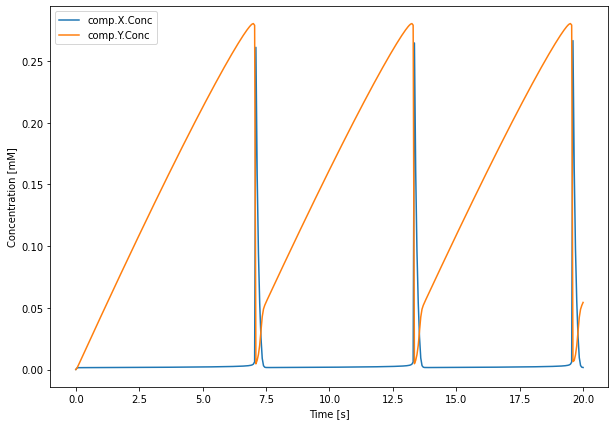

In [4]:
from matplotlib import pyplot as plt

with HDF5Handler('Brusselator_wm') as hdf:
    group = hdf.get(A=0.3, B=3)
    
    concs, = group.results
    
    fig = plt.figure(figsize=(10,7))
    
    # Plot data for run 0
    plt.plot(concs.time[0], 1e3 * concs.data[0,:,:])
    
    plt.xlabel('Time [s]')
    plt.ylabel('Concentration [mM]')
    plt.legend(concs.labels)
    plt.show()

After exiting the `with HDF5Handler('Brusselator_wm') as hdf:` block, the HDF5 file will be closed automatically. Note that it is also possible to do this manually:
```python
hdf = HDF5Handler('Brusselator_wm')
# Retrieve and plot data...
del hdf
```
The database handler would however need to be deleted (`del hdf`) in order to close the file.

Once the `HDF5Handler` object is created, we can retrieve a specific group of runs using the `get(...)` method:
```python
    group = hdf.get(A=0.3, B=3)
```
The keyword arguments should match the ones that were used in the calls to `sim.toDB(...)` earlier and should uniquely identify a run group.
Alternatively, we can retrieve the same run group by using the unique identifier string we gave to `sim.toDB(...)`:
```python
    group = hdf['Stoch_A0.3_B3']
```

The `group` object that is returned is an [HDF5Group](API_saving.rst#steps.API_2.saving.HDF5Group), we can access the saved result selectors with:
```python
    concs, = group.results
```
`group.results` returns a list of the result selectors that were added to the simulation with the `sim.toSave(...)` method. They are returned in the order in which they were added.
Since here we only added a single result selector, we use Python's tuple unpacking notation (see [python documentation](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences)) to attribute it to the `concs` variable.
The `concs` object then behaves exactly as a result selector and we can use it in the same way we did in the previous chapter.

We can thus access the data from the only run this run group contains (run 0) and plot it with:
```python
    plt.plot(concs.time[0], 1e3 * concs.data[0,:,:])
```

The Brusselator model generates oscillations in both X and Y concentrations. There is an influx of X that is converted to Y at a steady rate. Y slowly accumulates until it reaches some threshold concentration after which it is rapidly transformed to X through $2X + Y \rightarrow 3X$, the cycle then restart again. The existence of oscillations depends on the values of parameters `A` and `B`.

We can use `hdf.get(...)` to plot data from several run groups, at different values of `A` and `B`:

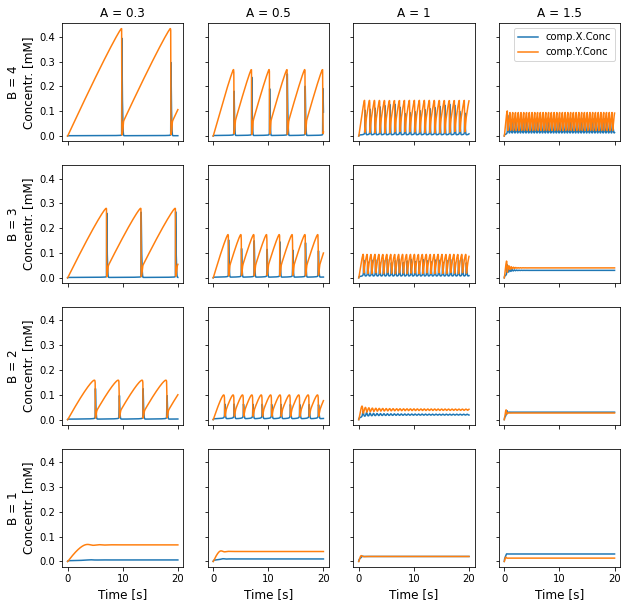

In [5]:
pltAVals = [0.3, 0.5, 1, 1.5]
pltBVals = [4, 3, 2, 1]

with HDF5Handler('Brusselator_wm') as hdf:
    fig, axes = plt.subplots(4, 4, figsize=(10,10), sharey=True, sharex=True)
    
    # Plot data
    for i, B in enumerate(pltBVals):
        for j, A in enumerate(pltAVals):
            concs, = hdf.get(A=A, B=B).results
            axes[i][j].plot(concs.time[0], concs.data[0,:,:] * 1e3)
            
    # Add legend and labels
    axes[0][-1].legend(concs.labels)
    for k in range(4):
        axes[0][k].set_title(f'A = {pltAVals[k]}')
        axes[-1][k].set_xlabel('Time [s]', size='large')
        axes[k][0].set_ylabel(f'B = {pltBVals[k]}\nConcentr. [mM]', size='large')
    plt.show()

For a given value of `A`, oscillations only arise of `B` is high enough. We can also see that the amplitude and frequency of oscillations also depends on the parameter values.

We know from theoretical analysis of the system that oscillations should only arise for $B > 1 + A^2$ ([wikipedia page](https://en.wikipedia.org/wiki/Brusselator)). We can thus try to check whether our implementation matches this.
In order to do so, we will use the [filter](API_saving.rst#steps.API_2.saving.DatabaseHandler.filter) method which returns sets of run groups that satisfy the parameter values given as keyword parameters. For example, in order to get all run groups that have `A = 0.3` we would write:
```python
groups = hdf.filter(A=0.3)
```

For each `A` value in `pltAVals`, we will retrieve all corresponding runs and plot the minimum and maximum value that the Y concentration reaches during the simulation, which is like an 'enveloppe' of the oscillations:

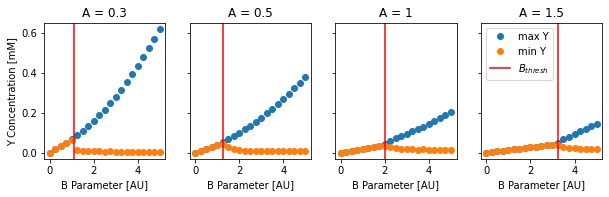

In [6]:
tSkip = int(5 // SIM_DT)

with HDF5Handler('Brusselator_wm') as hdf:
    fig, axes = plt.subplots(1, len(pltAVals), figsize=(10, 2.5), sharey=True)
    
    for A, ax in zip(pltAVals, axes):
        BVals = []
        minMaxVals = []
        for group in hdf.filter(A=A):
            BVals.append(group.B)
            YConc = 1e3 * group.results[0].data[0,tSkip:,1]
            minMaxVals.append([np.max(YConc), np.min(YConc)])

        Bthresh = 1 + A ** 2
        ax.plot(BVals, minMaxVals, 'o')
        ax.axvline(Bthresh, color='r')
        ax.set_xlabel('B Parameter [AU]')
        ax.set_title(f'A = {A}')
    axes[0].set_ylabel('Y Concentration [mM]')
    plt.legend(['max Y', 'min Y', '$B_{thresh}$'], loc=2)
        
plt.show()

We restrict the data to timepoints after 5 seconds (the `tSkip` variable gives us the corresponding time index). We also plot the critical value $B_{thresh} = 1 + A^2$ as a vertical red line in each of the subplots.

As expected, below the $B_{thresh} = 1 + A^2$ threshold, the minimum and maximum Y concentrations are equal, meaning the system reached a non-oscillatory equilibrium.

In the code, we retrieve the value of the `B` parameter for each run group with `group.B`. In general, the values of all parameters defined in `sim.toDB(...)` are directly accessible as attributes of run groups.

The order in which run groups are returned by `hdf.filter(A=A)` does not necessarily match the order in which the simulations were run. It is not a problem in our case because we plot the data with points; but if we wanted to join the points, we would have to order the run groups properly. For example, we could iterate through run groups with:
```python
for group in sorted(hdf.filter(A=A), key=lambda g: g.B):
```
Here we use the [sorted](https://docs.python.org/3.8/library/functions.html#sorted) python function with a custom ordering `key` that returns the value of the `B` parameter for each run group.

Finally, we would like to visualize the amplitude and frequency of X oscillations as a function of both `A` and `B` values, in a heatmap. We thus need to fill two matrices whose rows correspond to `B` values and whose columns correspond to `A` values.
One way to do it could be to iterate through all run groups in the database:
```python
for group in hdf:
    # Process group
    # Fill in values in matrices
```
The issue with this approach is that, although we have access to `A` and `B` values for each group with `group.A` and `group.B`, we do not know the indices that correspond to these values in the matrices.

We will thus instead use the [parameters](API_saving.rst#steps.API_2.saving.DatabaseHandler.parameters) property of the database handler to retrieve all recorded values for parameters `A` and `B`:

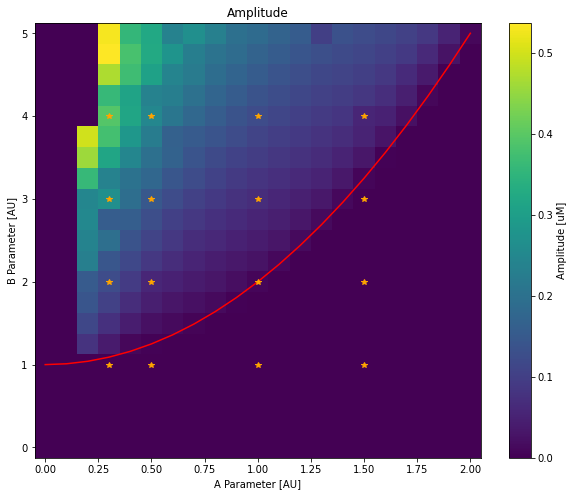

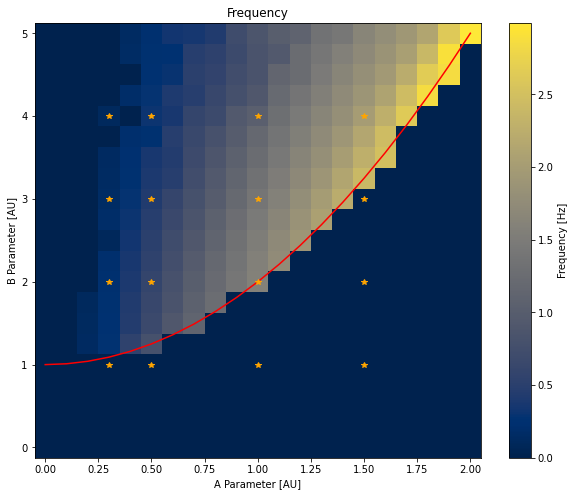

In [7]:
from scipy.signal import find_peaks

with HDF5Handler('Brusselator_wm') as hdf:
    # Get all possible values of parameters A and B
    Avals = sorted(hdf.parameters['A'])
    Bvals = sorted(hdf.parameters['B'])
    
    # Compute amplitudes and frequencies of X peaks
    amplitudes = np.zeros((len(Avals), len(Bvals)))
    frequencies = np.zeros((len(Avals), len(Bvals)))
    for i, B in enumerate(Bvals):
        for j, A in enumerate(Avals):
            concs, = hdf.get(A=A, B=B).results
            time = concs.time[0,tSkip:]
            XConc = concs.data[0,tSkip:,0] * 1e3
            
            # Compute amplitude
            amplitudes[i,j] = np.max(XConc) - np.min(XConc)
            
            # Compute frequency
            peaks, _ = find_peaks(XConc, prominence=amplitudes[i,j] * 0.7)
            if len(peaks) > 1:
                frequencies[i,j] = 1 / np.mean(np.diff(time[peaks]))
                
fig = plt.figure(figsize=(10, 8))
plt.pcolormesh(Avals, Bvals, amplitudes)
plt.plot(Avals, [(1 + A ** 2) for A in Avals], '-r')
plt.plot(*np.meshgrid(pltAVals, pltBVals), '*', color='orange')
plt.xlabel('A Parameter [AU]')
plt.ylabel('B Parameter [AU]')
plt.title('Amplitude')
plt.colorbar(label='Amplitude [uM]')

fig = plt.figure(figsize=(10, 8))
plt.pcolormesh(Avals, Bvals, frequencies, cmap=plt.get_cmap('cividis'))
plt.plot(Avals, [(1 + A ** 2) for A in Avals], '-r')
plt.plot(*np.meshgrid(pltAVals, pltBVals), '*', color='orange')
plt.xlabel('A Parameter [AU]')
plt.ylabel('B Parameter [AU]')
plt.colorbar(label='Frequency [Hz]')
plt.title('Frequency')

plt.show()

The values returned by e.g. `hdf.parameters['A']` are not necessarily ordered, we first order them with the `sorted` function.
We then create two numpy matrices with the correct dimensions and iterate through all run groups with a double `for` loop and a call to `hdf.get(A=A, B=B).results` to retrieve the result selector for each run group.

As before, we only consider the timepoints after 5 seconds. Amplitudes are computed by the difference between the maximum and minimum concentrations of X.
Peaks in X concentration are detected with the [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) function,  from the `scipy.signal` module. We then compute the average time between two peaks (with `np.mean(np.diff(time[peaks]))`) and compute the frequency from this value.

On Both plots, we add the $B_{thresh} = 1 + A^2$ line as a red line and orange stars on run groups that we plotted earlier. As expected, oscillations only arise above the line with higher frequency for high `A` values and higher amplitude when `B` is significantly above threshold.

## Spatial Brusselator model

The corresponding python script: [STEPS_Tutorial_DataSaving_square.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_DataSaving_square.py)

We now move to simulating the same model but on a tetrahedral mesh with the stochastic `'Tetexact'` solver. We will only look at runs with $A = 0.3$ and $B = 3$ so that the frequency of X oscillations is low enough to see the spatial propagation of waves of species X and the amplitude high enough to not be drowned in noise (since we will use a stochastic solver).

We declare the corresponding model, which is basically identical to the well-mixed one except for the addition of two diffusion rules for species X and Y:

In [8]:
DCST = 1e-13
A = 0.3
B = 3

mdl2 = Model()
r = ReactionManager()
with mdl2:
    X, Y = Species.Create()
    vsys = VolumeSystem.Create()
    with vsys:
        None <r[1]> X >r[2]> Y
        r[1].K = A * TF / CF, TF
        r[2].K = B * TF

        2*X + Y >r[3]> 3*X
        r[3].K = TF * (CF ** 2)
        
        Diffusion(X, DCST)
        Diffusion(Y, DCST)

### 2D simulation

We will first simulate this model on a flat square mesh and record the concentration of species X and Y in all tetrahedrons of the mesh:

In [9]:
ENDT = 1.5
SIM_DT = 0.01

mesh = TetMesh.LoadGmsh('meshes/square_9k.msh', scale=1e-6)
with mesh:
    comp = Compartment.Create(mesh.tets, vsys)
    
rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', mdl2, mesh, rng)

rs = ResultSelector(sim)

concs = rs.TETS().LIST(X, Y).Conc

sim.toSave(concs, dt=SIM_DT)

Model checking:
No errors were found


Before running the simulation, we need to decide how data will be recorded. One possibility would be to use an `HDF5Handler`, like we did in this chapter, and handle the plotting of spatial data manually, either with [matplotlib-3d](https://github.com/rougier/matplotlib-3d), [pyvista](https://docs.pyvista.org/), or some other external 3D plotting library.
The other possibility is to record the data with an `XDMFHandler` instead of an `HDF5Handler`. The `XDMFHandler` saves result selector data to an HDF5 file but also saves relevant mesh data in the HDF5 file. In addition, it creates `.xmf` [XDMF](https://www.xdmf.org/index.php/Main_Page) files that describe the spatial structure of the data; these files can then be oppened by scientific visualization softwares like [Paraview](https://www.paraview.org/).

In this chapter, we will cover the usage of `XDMFHandler` from data recording to visualization with Paraview. We thus run our simulation on our flat square mesh and record the data with an `XDMFHandler`:

In [10]:
with XDMFHandler('Brusselator_square') as hdf:
    sim.toDB(hdf, f'square_A{A}_B{B}_D{DCST}', A=A, B=B, DCST=DCST)

    sim.newRun()
    
    sim.comp.X.Conc = 5e-6
    sim.comp.Y.Conc = 1.4e-4

    sim.run(ENDT)

Note that, regarding data saving code, the only modification is the use of `XDMFHandler` instead of `HDF5Handler` as well as different file prefix and unique run identifier. 
We set the initial conditions to values that are close to the first oscillation, so that we do not have to wait for 5 seconds before any X oscillations (see the first plot).

### Loading the data with Paraview

After running the simulation, we have two new files in the current directory:

- `Brusselator_square.h5` that contains the result selector data and additional mesh information. This file can be then be loaded with a `HDF5Handler` to retrieve the result selector data.
- `square_A0.3_B3_D1e-13_Run0_rank0.xmf`, an [XDMF](https://www.xdmf.org/index.php/Main_Page) file that describe the data corresponding to the run 0 of the `square_A0.3_B3_D1e-13` run group. You can ignore the `_rank0` part for now, it only plays a role when running distributed simulations. This file can be opened by [Paraview](https://www.paraview.org/) to visualize the simulation.

Note that if we simulated several runs, we would have an XDMF file for each run.

If you did not install [Paraview](https://www.paraview.org/) on your machine, you can skip to the [next section](#Visualizing-the-data-with-Paraview). Otherwise, launch [Paraview](https://www.paraview.org/), go to "File" $\rightarrow$ "Open" and select the `square_A0.3_B3_D1e-13_Run0_rank0.xmf` file (if you did not run the code on your machine, you can download both `.h5` and `.xmf` file from the [github repository](https://github.com/CNS-OIST/STEPS_Example/raw/master/user_manual/source/data/DataSaving_HDF5_data.zip)).

Depending on your version of Paraview, you might be asked to select a file reader. If so, choose the "XDMF Reader" option.

You should now see the file as a data source in the paraview pipeline (top left pane):

<img src="images/paraview_pipeline_1.png"/>

Click on the green "Apply" button to confirm the loading of the file:

<img src="images/paraview_load_apply.png"/>

You should then see something like this:

<img src="images/paraview_file_loaded_1.png"/>

The mesh is displayed and tetrahedrons are colored according to the concentration of X species (1) at time 0 (2).
We can edit the colormap by clicking on the "Edit Color Map" button (3) or with "View" $\rightarrow$ "Color Map Editor".
Let us now change the colormap:

<img src="images/paraview_colormap_1.png"/>

Select the "Turbo" colormap (1), click on the "Rescale to data range over all timesteps" button (2) and close the colormap editor (3).
The colormap is initially scaled to the values of X concentrations at time 0, which is a very narrow range. Clicking on (2) rescales it by considering all timesteps in the simulation.

We can now play the simulation:

<img src="images/paraview_animation_1.png"/>

We can control the timestep being displayed by the buttons in (1). Try the "Play" button for example. It is also possible to display which timestep is curently being viewed by opening the animation view (2) "View" $\rightarrow$ "Animation View". You can then drag around the cursor (3) and visualize different timesteps.

### Visualizing the data with Paraview

If you do not have Paraview installed on your machine, here is a web version of the visualization of our simulation:

<div class="ParaviewFrameWrapper">
<iframe src="https://kitware.github.io/paraview-glance/app?name=square.vtkjs&url=https://raw.githubusercontent.com/CNS-OIST/STEPS_Example/master/user_manual/source/data/square_A0.3_B3_D1e-13_Run_0.vtkjs" class="ParaviewFrame" id="Glance_1" style="display:none;">
</iframe>
<script type="text/javascript" language="javascript">
    setTimeout(function() {document.getElementById("Glance_1").style.display = "block";}, 2000);
</script>
</div>

The simulation can be played by opening the menu (1), switching to the "GLOBAL" tab (2), and clicking on the Play button (3):

<img src="images/web_paraview_1.png"/>

In the "DATASETS" tab, the data plotted on the mesh can be changed ("Color By" option).

With Paraview, the data from STEPS simulations can be directly visualized. But, although this is not the focus of this chapter, Paraview can also be used to analyze the data. The interested reader can refer to the [Paraview guide](https://docs.paraview.org/en/latest/) for more information.

### 3D simulation

The corresponding python script: [STEPS_Tutorial_DataSaving_box.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_DataSaving_box.py)

Our previous simulation on a flat square mesh was relatively easy to visualize, we just needed to see the surface of the mesh. As a demonstration of the usefulness of Paraview filters to visualize fully 3D STEPS simulations, we will run the same model but this time on a cubic mesh:

In [11]:
ENDT = 1.5
SIM_DT = 0.01

mesh = TetMesh.LoadGmsh('meshes/box_110k.msh', scale=1e-6)
with mesh:
    comp = Compartment.Create(mesh.tets, vsys)
    
rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', mdl2, mesh, rng)

rs = ResultSelector(sim)

concs = rs.TETS().LIST(X, Y).Conc

sim.toSave(concs, dt=SIM_DT)

options = dict(compression="gzip", compression_opts=9)

with XDMFHandler('Brusselator_box', hdf5DatasetKwArgs=options) as hdf:
    sim.toDB(hdf, f'box_A{A}_B{B}_D{DCST}', A=A, B=B, DCST=DCST)

    sim.newRun()
    
    sim.comp.X.Conc = 5e-6
    sim.comp.Y.Conc = 1.6e-4

    sim.run(ENDT)

Model checking:
No errors were found


Since the there will be much more data to save, we use the `hdf5DatasetKwArgs` keyword argument that is a dictionnary of options given to HDF5 datasets (see the [corresponding h5py documentation](https://docs.h5py.org/en/stable/high/group.html#h5py.Group.create_dataset)). In our case, we want to enable "gzip" compression with the highest compression level (see the [h5py documentation](https://docs.h5py.org/en/stable/high/dataset.html#dataset-compression) for other compression options).

Note that this simulation takes much more time to run than the previous one, since it has roughly 10 times more tetrahedrons. You can download the resulting files (`Brusselator_box.h5` and `box_A0.3_B3_D1e-13_Run0_rank0.xmf`) from the [github repository](https://github.com/CNS-OIST/STEPS_Example/raw/master/user_manual/source/data/DataSaving_HDF5_data.zip).

### Loading the data

If you did not install [Paraview](https://www.paraview.org/) on your machine, you can skip to the [next section](#Visualizing-the-data).

Launch Paraview and load the `box_A0.3_B3_D1e-13_Run0_rank0.xmf` file like we did previously. After editing the colorbar, you should see the box and be able to visualize the simulation:

<img src="images/paraview_file_loaded_box.png"/>

Set the opacity (1) to 0.5. As you can see, this does not allow us to see inside the mesh, it only makes the surface of the mesh transparent, which will be needed to see the filters we will add. We will add filters that compute the [isosurface](https://en.wikipedia.org/wiki/Isosurface) (or contour) for `X.Conc = 5e-5`. In this way, we will be able to see the propagating waves inside the mesh.

First select the data source (2) and do "Filters" $\rightarrow$ "Search..." (or Ctrl + Space). This opens a small window that allows you to search for a filter to apply to the selected data. Type "cell data" and select the "Cell Data to Point Data" filter:

<img src="images/paraview_celldata_filter.png"/>

Hit Enter and click "Apply". This filter converts our data that is centered on tetrahedrons, to data centered on vertices. This steps is necessary for computing the isosurface since the "Contour" filter only operates on point data.

Select "CellDataToPointData1" in the pipeline and add the "Contour" filter to it: Ctrl + Space, type "contour", and select the "Contour" filter:

<img src="images/paraview_contour_filter.png"/>

This should open the contour filter settings:

<img src="images/paraview_contour_box.png"/>

Edit the contour value (1) to 5e-5 and hit the "Apply" button (2). You should now be able to see the added contour through the transparent mesh surface:

<img src="images/paraview_contour_settings_box.png"/>

Check that both the original data source and the contour filters are visible (1) by clicking on the eye icon to their left. Change the coloring of the contour to "Y.Conc" (2) so we can see the concentration of Y on the surfaces on which X.Conc = 5e-5.

### Visualizing the data

The end result should look something like this:

<div class="ParaviewFrameWrapper">
<iframe src="https://kitware.github.io/paraview-glance/app?name=square.vtkjs&url=https://raw.githubusercontent.com/CNS-OIST/STEPS_Example/master/user_manual/source/data/box_A0.3_B3_D1e-13_Run_0.vtkjs" class="ParaviewFrame" id="Glance_2" style="display:none;">
</iframe>
<script type="text/javascript" language="javascript">
    setTimeout(function() {document.getElementById("Glance_2").style.display = "block";}, 2000);
</script>
</div>

We can see that there are two [isosurfaces](https://en.wikipedia.org/wiki/Isosurface), in front and behind any wavefront. The surface in front of the wavefront is associated with high Y concentrations, and the surface behind the wavefront is associated with low Y concentrations since the Y species were converted to X during the wave.